Now I run the real data (Ctrl data in AD_vs_Ctrl dataset)

Convert to dB Scale

- 由于现在我处理的ctrl的spectrogram的freqs pts和eye MEG data 一样，所以你可以用SGM_net_large_eye_close来simulate PSD。
- 但是，顺序是不一样的，我用的是36-MEG data的顺序训练的这个net。

In [1]:
RUN_PYTHON_SCRIPT = False

False

In [2]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange, tqdm
import time
from joblib import Parallel, delayed

plt.style.use(FIG_ROOT/"base.mplstyle")

In [4]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [5]:
from utils.reparam import theta2raw_torch, raw2theta_torch, raw2theta_np
from spectrome import Brain
from sgm.sgm import SGM
from utils.stable import paras_stable_check
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time
from models.lstm import LSTM_SGM
from models.loss import  weighted_mse_loss, reg_R_loss, lin_R_loss, lin_R_fn, reg_R_fn
from utils.standardize import std_mat, std_vec

In [6]:
# pkgs for pytorch ( Mar 27, 2023) 
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    torch.cuda.set_device(2)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    torch.backends.cudnn.benchmark = True
else:
    torch.set_default_tensor_type(torch.DoubleTensor)

# Data, fn and paras

In [7]:
# get order idx
# idx from 36-MEG order to Ctrl-data order
# org_order: ctrl data order
# target_order: SGMnet order, SC order
org_order = np.loadtxt(DATA_ROOT/"AD_vs_Ctrl_ts/roi_order.txt", dtype=str);
target_order0 = np.loadtxt(DATA_ROOT/"DK_atlas_36MEG.txt", dtype=str);
target_order = np.array([f"ctx-{roi_name.split('_')[1].lower()}h-{roi_name.split('_')[0].lower()}" for roi_name in target_order0[:68]]);
org2target_idxs = np.array([np.where(org_order==roi)[0][0] for roi in target_order]);
(org_order[org2target_idxs] == target_order).mean()

1.0

In [8]:
psd_all_full0 = load_pkl(DATA_ROOT/"AD_vs_Ctrl_ts/spectrogram_scipy.pkl");

psd_all_full = np.array([res["spectrogram"] for res in psd_all_full0]);
psd_all_full = 10 * np.log10(psd_all_full) # to dB scale
# make the ctrl data order is compatible to SGM net 
psd_all_full = psd_all_full[:, org2target_idxs]
time_points = psd_all_full0[0]["times"]
freqs = psd_all_full0[0]["freqs"];

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/spectrogram_scipy.pkl


In [9]:
# Load the Connectome
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [10]:
# some constant parameters for this file
paras = edict()

## I reorder them in an alphabetical order and I change tauC to tauG (Mar 27, 2023)
## the orginal order is taue, taui, tauC, speed, alpha, gii, gei
## paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
## paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
##

# alpha, gei, gii, taue, tauG, taui, speed 
paras.par_low = np.array([0.1, 0.001,0.001, 0.005, 0.005, 0.005, 5])
paras.par_high = np.asarray([1, 0.7, 2, 0.03, 0.03, 0.20, 20])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"]

paras.C = brain.reducedConnectome
paras.D = brain.distance_matrix
paras.freqs = freqs

# Train the model

In [11]:
trained_model = load_pkl_folder2dict(RES_ROOT/"SGM_net_large_eye_close", excluding=['opt*'])
sgm_net = trained_model.model;
sgm_net.eval();

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large_eye_close/freqs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large_eye_close/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large_eye_close/loss_fn.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large_eye_close/loss_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large_eye_close/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large_eye_close/paras.pkl


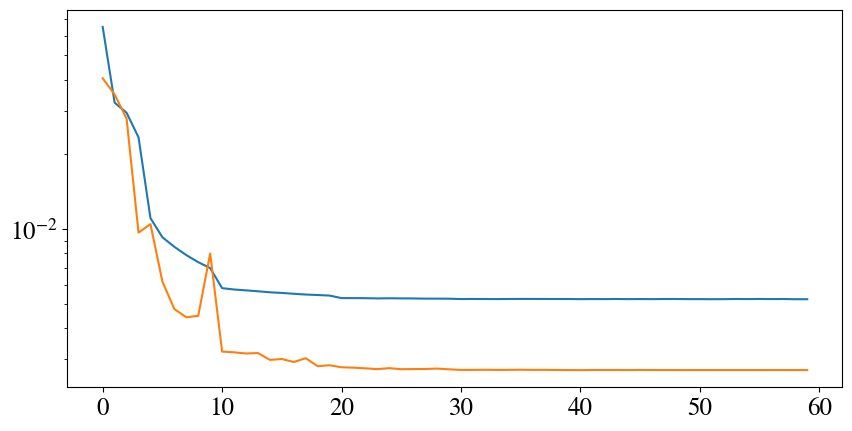

In [12]:
if not RUN_PYTHON_SCRIPT:
    plt.plot(np.array(trained_model.loss)/10)
    plt.plot(trained_model.loss_test)
    #plt.xticks(np.arange(0, 120, 14));
    plt.yscale("log")

In [13]:
# functions to generate training sample (Apr 1, 2023)
def random_choice(n, batchsize=1, len_seg=None):
    """Randomly select the lower and upper bound of the segment
        args:
            n: len of the total time series
    """
    if len_seg is None:
        len_seg = torch.randint(low=10, high=100, size=(1, ))
    up_bd = torch.randint(low=len_seg.item(), high=n, size=(batchsize, ))
    low_bd = up_bd - len_seg
    return low_bd, up_bd


def random_samples_rnn(X, Y=None, batchsize=1, 
                       bds=None, 
                       is_std=True, 
                       theta2raw_fn=None):
    """Randomly select a sample from the whole segment
        args:
            X: PSD, num_seq x 68 x nfreq or 
               PSD, num_sub x num_seq x 68 x nfreq
            Y: params, num x 7, in original sgm scale
        return:
            X_seqs: len_seq x batchsize x num_fs
            Y_seqs: len_seq x batchsize x 7
            
    """
    if X.ndim == 4:
        # if multiple subjects, pick up a subject
        num_sub = X.shape[0]
        sub_idx = np.random.randint(low=0, high=num_sub)
        X = X[sub_idx]
        
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X)
    if is_std:
        #X = X/X.std(axis=(1, 2), keepdims=True)
        # Let std for each ROI and each data
        X = (X-X.mean(axis=2, keepdims=True))/X.std(axis=2, keepdims=True)
    if Y is not None:
        if not isinstance(Y, torch.Tensor):
            Y = torch.tensor(Y)
        if theta2raw_fn: 
            Y = theta2raw_fn(Y)
    if bds is None:
        low_bds, up_bds = random_choice(len(X), batchsize)
    else:
        low_bds, up_bds = bds

    X = X.flatten(1)
    X_seqs = []
    Y_seqs = []
    for low_bd, up_bd in zip(low_bds, up_bds):
        X_seq = X[low_bd:up_bd, :].unsqueeze(1)
        X_seqs.append(X_seq)
        if Y is not None:
            Y_seq = Y[low_bd:up_bd].unsqueeze(1)
            Y_seqs.append(Y_seq)
    if Y is not None:
        return torch.cat(X_seqs, dim=1), torch.cat(Y_seqs, dim=1)
    else:
        return torch.cat(X_seqs, dim=1)
        

In [14]:
def evaluate(all_data):
    num_sub, len_seq, _, _ = all_data.shape
    all_data_raw = torch.tensor(all_data).transpose(1, 0)
    all_data_input = (all_data_raw - all_data_raw.mean(axis=-1, keepdims=True))/all_data_raw.std(axis=-1, keepdims=True);
    all_data_input = all_data_input.flatten(2);
    
    with torch.no_grad():
        Y_pred = rnn(all_data_input);
        X_pred = sgm_net(Y_pred.flatten(0, 1));
    corrs = reg_R_fn(all_data_raw.flatten(0, 1), X_pred);
    corrs = corrs.reshape(len_seq, num_sub, -1).transpose(1, 0)
    return corrs.detach().numpy()

In [15]:
paras_rnn = edict()
# batchsize is not in fact used.
paras_rnn.batchsize = 128
paras_rnn.niter = 500
paras_rnn.loss_out = 5
paras_rnn.eval_out = 20
paras_rnn.clip = 1 # from 
paras_rnn.lr_step = 10

paras_rnn.k = 1
paras_rnn.hidden_dim = int(1024/1)
paras_rnn.output_dim = 7
paras_rnn.input_dim = 68*len(paras.freqs)
paras_rnn.is_bidirectional = False
paras_rnn.unstable_pen = 10000 # Whether to filter out the unstable sps or not, if 0 not, if large number, yes
paras_rnn.loss_name = "corr" # linR, corr, wmse or mse
#paras.names = ["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"]
# 1 dynamic, 0 static
paras_rnn.dy_mask = [1, 1, 1, 1, 1, 1, 0] 
stat_part = "_".join(np.array(paras.names)[np.array(paras_rnn.dy_mask)==0][:-1])
if len(stat_part) > 0:
    folder_name = f"LSTM_simu_net_ctrl_{paras_rnn.loss_name}_{stat_part}";
else:
    folder_name = f"LSTM_simu_net_ctrl_{paras_rnn.loss_name}";
paras_rnn.save_dir = RES_ROOT/folder_name


psd_all = psd_all_full
#  all_data is the real data, should be num_sub x len_seq x nrois x nfreqs
#  or len_seq x nrois x nfreqs
all_data = psd_all.transpose(0, 3, 1, 2)

all_data_raw = torch.tensor(all_data).transpose(1, 0)
all_data_input = (all_data_raw - all_data_raw.mean(axis=-1, keepdims=True))/all_data_raw.std(axis=-1, keepdims=True);
all_data_input = all_data_input.flatten(2);

In [16]:
rnn = LSTM_SGM(input_dim=paras_rnn.input_dim, 
               hidden_dim=paras_rnn.hidden_dim, 
               output_dim=paras_rnn.output_dim, 
               is_bidirectional=paras_rnn.is_bidirectional, 
               prior_bds=torch.tensor(paras.prior_bds), 
               k = paras_rnn.k, 
               dy_mask = paras_rnn.dy_mask
)
if paras_rnn.loss_name.startswith("corr"):
    loss_fn = reg_R_loss
elif paras_rnn.loss_name.startswith("linR"):
    loss_fn = lin_R_loss
elif paras_rnn.loss_name.startswith("wmse"):
    loss_fn = weighted_mse_loss
elif paras_rnn.loss_name.startswith("mse"):
    loss_fn = nn.MSELoss()
else:
    raise KeyError("No such loss")

optimizer = torch.optim.AdamW(rnn.parameters(), lr=2e-4, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=0.9, verbose=True)

Adjusting learning rate of group 0 to 2.0000e-04.


In [23]:
# training
loss_cur = 0
losses = []
losses_test = []

t0 = time.time()
sgm_net.eval()
loss_add = 0
for ix in range(paras_rnn.niter):
    rnn.train()
    # Here because the whole dataset is not large, 
    # I use them as one batch
    # Of course, you can use random_samples_rnn to draw 
    # X_seq = random_samples_rnn(all_data, 
    #                           batchsize=paras_rnn.batchsize)
    X_seq = all_data_input
    # Zero the gradients
    optimizer.zero_grad()
    
    theta_pred = rnn(X_seq)
    X_pred = sgm_net(theta_pred.flatten(0, 1))
    loss_main = loss_fn(X_seq.flatten(0, 1).reshape(-1, 68, len(paras.freqs)),
                   X_pred)
    if paras_rnn.unstable_pen > 0:
        unstable_inds = paras_stable_check(theta_pred.flatten(0, 1).detach().numpy());
        unstable_inds = torch.tensor(unstable_inds).reshape(*theta_pred.shape[:2])
        loss_add = (paras_rnn.unstable_pen * unstable_inds.unsqueeze(-1) * theta_pred).mean();
    loss = loss_main + loss_add
    
    # Perform backward pass
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), paras_rnn.clip)
    # Perform optimization
    optimizer.step()
    
    if ix % paras_rnn.lr_step == (paras_rnn.lr_step-1):
        scheduler.step()
    
    loss_cur = loss_cur + loss_main.item()
    if ix % paras_rnn.loss_out == (paras_rnn.loss_out-1):
        losses.append(loss_cur/paras_rnn.loss_out)
        print(f"At iter {ix+1}/{paras_rnn.niter}, "
              f"the losses are {loss_cur/paras_rnn.loss_out:.5f} (train). "
              f"The time used is {delta_time(t0):.3f}s. "
             )
        loss_cur = 0
        t0 = time.time()
        
    if ix % paras_rnn.eval_out == (paras_rnn.eval_out-1):
        rnn.eval()
        loss_test = evaluate(all_data).mean()
        losses_test.append(loss_test)
        print(f"="*100)
        print(f"At iter {ix+1}/{paras_rnn.niter}, "
              f"the losses on all data are {loss_test:.5f}. "
              f"The time used is {delta_time(t0):.3f}s. "
             )
        print(f"="*100)
        t0 = time.time()
    


At iter 5/500, the losses are -0.72958 (train). The time used is 22.293s. 
Adjusting learning rate of group 0 to 1.8000e-04.
At iter 10/500, the losses are -0.77988 (train). The time used is 17.861s. 
At iter 15/500, the losses are -0.78050 (train). The time used is 22.409s. 
Adjusting learning rate of group 0 to 1.6200e-04.
At iter 20/500, the losses are -0.78125 (train). The time used is 22.713s. 
At iter 20/500, the losses on all data are 0.78185. The time used is 1.830s. 
At iter 25/500, the losses are -0.78228 (train). The time used is 25.251s. 
Adjusting learning rate of group 0 to 1.4580e-04.
At iter 30/500, the losses are -0.78358 (train). The time used is 20.801s. 
At iter 35/500, the losses are -0.78474 (train). The time used is 22.127s. 
Adjusting learning rate of group 0 to 1.3122e-04.
At iter 40/500, the losses are -0.78536 (train). The time used is 21.858s. 
At iter 40/500, the losses on all data are 0.78558. The time used is 1.428s. 
At iter 45/500, the losses are -0.785

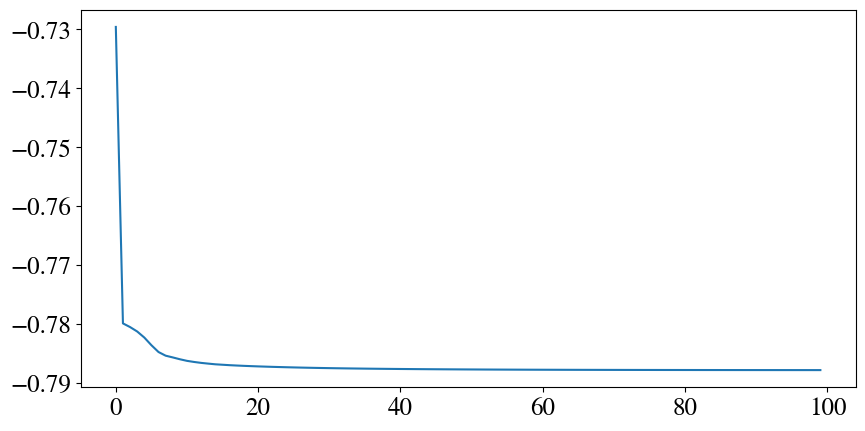

In [24]:
if not RUN_PYTHON_SCRIPT:
    plt.plot(losses[:])
    #plt.yscale("log")

# Save

In [32]:
if (paras_rnn.save_dir).exists():
    trained_model = load_pkl_folder2dict(paras_rnn.save_dir)
else:
    trained_model = edict()
    trained_model.model = rnn
    trained_model.loss_fn = loss_fn
    trained_model.optimizer = optimizer
    trained_model.paras = paras_rnn
    trained_model.loss = losses
    save_pkl_dict2folder(paras_rnn.save_dir, trained_model, is_force=True)

/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr
Create a folder /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/model.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/loss_fn.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/optimizer.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/paras.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/loss.pkl


# PSD 

In [17]:
trained_model = load_pkl_folder2dict(paras_rnn.save_dir);

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/loss_fn.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/optimizer.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/paras.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/sgm_paramss_est.pkl


In [21]:
trained_model.model.eval()
with torch.no_grad():
    Y_pred = trained_model.model(all_data_input)
sgm_paramss_est = Y_pred.cpu().numpy().transpose(1, 0, 2)
trained_model.sgm_paramss_est = sgm_paramss_est
save_pkl_dict2folder(paras_rnn.save_dir, trained_model, is_force=False)

/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/loss.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/loss_fn.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/model.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/optimizer.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/paras.pkl exists! Use is_force=True to save it anyway
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/sgm_paramss_est.pkl


In [19]:
# calculate rec PSD and save, only need once
sgmmodel = SGM(paras.C, paras.D, paras.freqs)
def _run_fn(sgm_param):
    cur_PSD = sgmmodel.run_local_coupling_forward(sgm_param)
    return cur_PSD[:68]
X_recs = []
for sgm_params_est in tqdm(trained_model.sgm_paramss_est):
    if np.sum(paras_rnn.dy_mask) == 0:
        # only for all static model
        X_rec = _run_fn(sgm_params_est[0])
        X_rec = np.tile(X_rec, (len(sgm_params_est), 1, 1))
    else:
        with Parallel(n_jobs=20) as parallel:
            X_rec = parallel(delayed(_run_fn)(param) for param in sgm_params_est)
    X_recs.append(X_rec)
    
# save
trained_model.Rec_PSD = np.array(X_recs)
save_pkl_dict2folder(paras_rnn.save_dir, trained_model, is_force=False)

100%|████████████████████████████████████████████████████████████████████████████| 92/92 [06:23<00:00,  4.17s/it]


/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/loss.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/loss_fn.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/model.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/optimizer.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/paras.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_ctrl_corr/sgm_paramss_est.pkl exists! Use is_force=True to save it anyway
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/noteboo